In [35]:
import os
import sys
import urllib.request
import re
import json
import csv
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
client_id = "6edzCNnNWRuAcEfH4xKc"
client_secret = "T6ZF8xVRNj"
def korean_font():
    plt.rc('font', family='AppleGothic')
    plt.rcParams['axes.unicode_minus'] = False
    

In [36]:
class NaverDataLabOpenAPI():
    """
    네이버 데이터랩 오픈 API 컨트롤러 클래스
    """

    def __init__(self, client_id, client_secret):
        """
        인증키 설정 및 검색어 그룹 초기화
        """
        self.client_id = client_id
        self.client_secret = client_secret
        self.keywordGroups = []
        self.url = "https://openapi.naver.com/v1/datalab/search"

    def add_keyword_groups(self, group_dict):
        """
        검색어 그룹 추가
        """

        keyword_gorup = {
            'groupName': group_dict['groupName'],
            'keywords': group_dict['keywords']
        }
        
        self.keywordGroups.append(keyword_gorup)
        print(f">>> Num of keywordGroups: {len(self.keywordGroups)}")
        
    def get_data(self, startDate, endDate, timeUnit, device, ages, gender):
        """
        요청 결과 반환
        timeUnit - 'date', 'week', 'month'
        device - None, 'pc', 'mo'
        ages = [], ['1' ~ '11']
        gender = None, 'm', 'f'
        """

        # Request body
        body = json.dumps({
            "startDate": startDate,
            "endDate": endDate,
            "timeUnit": timeUnit,
            "keywordGroups": self.keywordGroups,
            "device": device,
            "ages": ages,
            "gender": gender
        }, ensure_ascii=False)
        
        # Results
        request = urllib.request.Request(self.url)
        request.add_header("X-Naver-Client-Id",self.client_id)
        request.add_header("X-Naver-Client-Secret",self.client_secret)
        request.add_header("Content-Type","application/json")
        response = urllib.request.urlopen(request, data=body.encode("utf-8"))
        rescode = response.getcode()
        if(rescode==200):
            # Json Result
            result = json.loads(response.read())
            
            df = pd.DataFrame(result['results'][0]['data'])[['period']]
            for i in range(len(self.keywordGroups)):
                tmp = pd.DataFrame(result['results'][i]['data'])
                tmp = tmp.rename(columns={'ratio': result['results'][i]['title']})
                df = pd.merge(df, tmp, how='left', on=['period'])
            self.df = df.rename(columns={'period': '날짜'})
            self.df['날짜'] = pd.to_datetime(self.df['날짜'])
            
        else:
            print("Error Code:" + rescode)
            
        return self.df
    
    def plot_daily_trend(self):
        """
        일 별 검색어 트렌드 그래프 출력
        """
        colList = self.df.columns[1:]
        n_col = len(colList)

        fig = plt.figure(figsize=(12,6))
        plt.title('일 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=self.df['날짜'], y=self.df[colList[i]], label=colList[i])
        plt.legend(loc='upper right')
        
        return fig
    
    def plot_monthly_trend(self):
        """
        월 별 검색어 트렌드 그래프 출력
        """
        df = self.df.copy()
        df_0 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(0).reset_index().rename(columns={'날짜': '월'})
        df_1 = df.groupby(by=[df['날짜'].dt.year, df['날짜'].dt.month]).mean().droplevel(1).reset_index().rename(columns={'날짜': '년도'})

        df = pd.merge(df_1[['년도']], df_0, how='left', left_index=True, right_index=True)
        df['날짜'] = pd.to_datetime(df[['년도','월']].assign(일=1).rename(columns={"년도": "year", "월":'month','일':'day'}))
        
        colList = df.columns.drop(['날짜','년도','월'])
        n_col = len(colList)
                
        fig = plt.figure(figsize=(12,6))
        plt.title('월 별 검색어 트렌드', size=20, weight='bold')
        for i in range(n_col):
            sns.lineplot(x=df['날짜'], y=df[colList[i]], label=colList[i])
        plt.legend(loc='upper right')
        
        return fig
    
    def plot_pred_trend(self, days):
        """
        검색어 시계열 트렌드 예측 그래프 출력
        days: 예측일수
        """
        colList = self.df.columns[1:]
        n_col = len(colList)
        
        fig_list = []
        for i in range(n_col):
            
            globals()[f"df_{str(i)}"] = self.df[['날짜', f'{colList[i]}']]
            globals()[f"df_{str(i)}"] = globals()[f"df_{str(i)}"].rename(columns={'날짜': 'ds', f'{colList[i]}': 'y'})

            m = Prophet()
            m.fit(globals()[f"df_{str(i)}"])

            future = m.make_future_dataframe(periods=days)
            forecast = m.predict(future)
            forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
            
            globals()[f"fig_{str(i)}"] = m.plot(forecast, figsize=(12,6))
            plt.title(colList[i], size=20, weight='bold')
            
            fig_list.append(globals()[f"fig_{str(i)}"])
            
        return fig_list

In [59]:
keyword_group_set = {
    'keyword_group_1': {'groupName': "관광", 'keywords': ["관광","부산"]},
    'keyword_group_2': {'groupName': "바다", 'keywords': ["바다","부산"]},
    'keyword_group_3': {'groupName': "숙소", 'keywords': ["숙소","부산"]},
    'keyword_group_4': {'groupName': "음식점", 'keywords': ["음식점","부산"]},
    'keyword_group_5': {'groupName': "시장", 'keywords': ["시장","부산"]}
}

In [60]:
# API 인증 정보 설정
client_id = "6edzCNnNWRuAcEfH4xKc"
client_secret = "T6ZF8xVRNj"

# 요청 파라미터 설정
startDate = "2019-01-01"
endDate = "2019-12-31"
timeUnit = 'date'
device = ''
ages = []
gender = ''

# 데이터 프레임 정의
naver = NaverDataLabOpenAPI(client_id=client_id, client_secret=client_secret)

naver.add_keyword_groups(keyword_group_set['keyword_group_1'])
naver.add_keyword_groups(keyword_group_set['keyword_group_2'])
naver.add_keyword_groups(keyword_group_set['keyword_group_3'])
naver.add_keyword_groups(keyword_group_set['keyword_group_4'])
naver.add_keyword_groups(keyword_group_set['keyword_group_5'])

df = naver.get_data(startDate, endDate, timeUnit, device, ages, gender)

>>> Num of keywordGroups: 1
>>> Num of keywordGroups: 2
>>> Num of keywordGroups: 3
>>> Num of keywordGroups: 4
>>> Num of keywordGroups: 5


In [64]:
df

,날짜,관광,바다,숙소,음식점,시장
0,2019-01-01,14.76721,18.78361,14.74076,16.03033,15.51450
1,2019-01-02,15.89586,18.14434,15.78784,16.29045,15.95758
2,2019-01-03,15.77241,17.94594,15.58063,16.18243,15.88263
3,2019-01-04,15.19486,17.33312,14.99206,15.79225,15.31390
4,2019-01-05,14.52252,17.33092,14.56882,15.60708,15.03615
...,...,...,...,...,...,...
360,2019-12-27,17.05757,19.79543,17.65717,18.45957,17.60647
361,2019-12-28,16.79084,20.13049,17.40587,18.51468,17.76518
362,2019-12-29,16.66078,20.88660,17.22511,18.31849,17.64174
363,2019-12-30,21.87858,25.15871,22.36575,23.30923,22.39000


In [61]:
df.head()

,날짜,관광,바다,숙소,음식점,시장
0,2019-01-01,14.76721,18.78361,14.74076,16.03033,15.51450
1,2019-01-02,15.89586,18.14434,15.78784,16.29045,15.95758
2,2019-01-03,15.77241,17.94594,15.58063,16.18243,15.88263
3,2019-01-04,15.19486,17.33312,14.99206,15.79225,15.31390
4,2019-01-05,14.52252,17.33092,14.56882,15.60708,15.03615


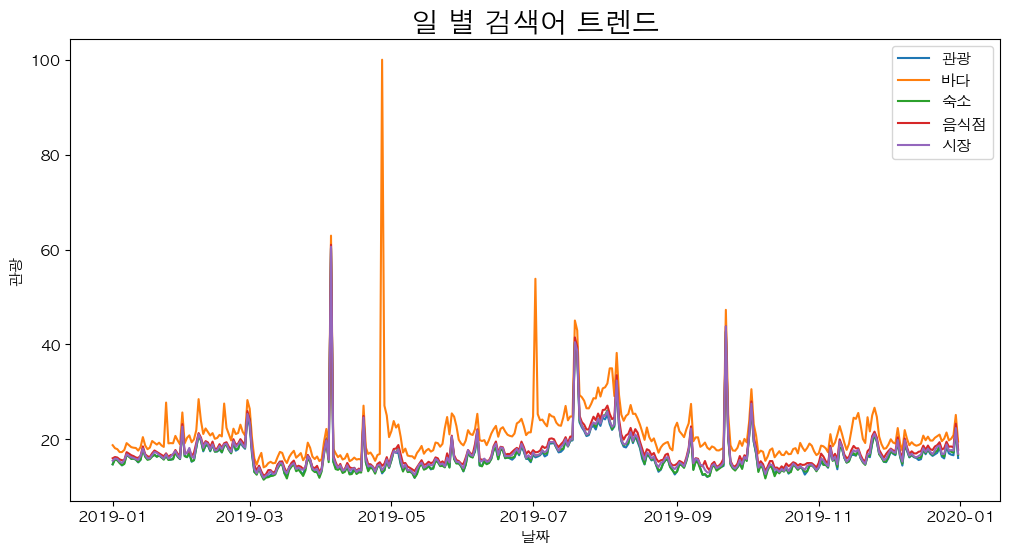

In [63]:
korean_font()
fig_1 = naver.plot_daily_trend()

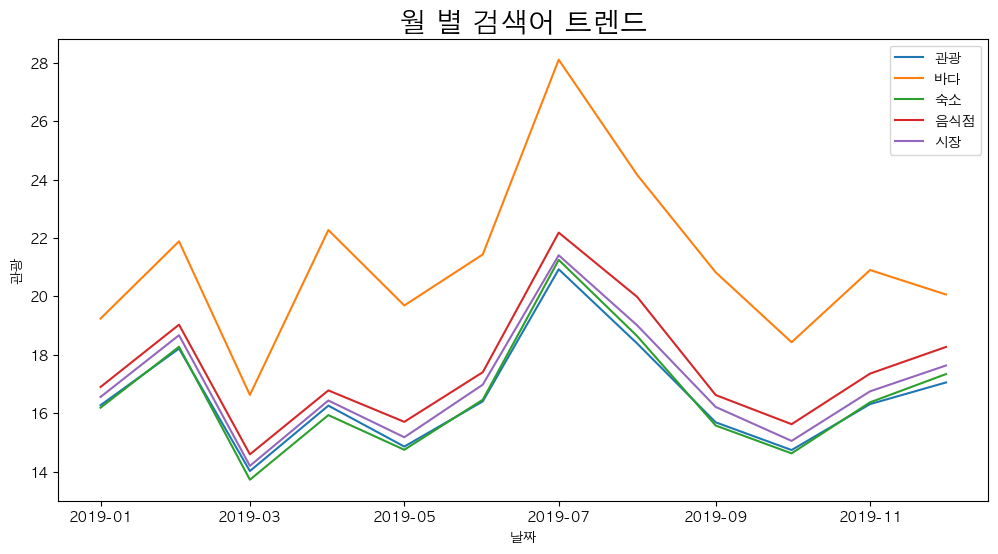

In [46]:
fig_2 = naver.plot_monthly_trend()